https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [3]:
CUDA_LAUNCH_BLOCKING = 1

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import torch
# torch.manual_seed(100)

!pip install transformers

     |████████████████████████████████| 3.5 MB 28.0 MB/s 
     |████████████████████████████████| 596 kB 65.9 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 895 kB 65.9 MB/s 
     |████████████████████████████████| 6.5 MB 53.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
train_set = pd.read_csv("vaccine_train_set.csv") #read train data set
validation_set = pd.read_csv("vaccine_validation_set.csv") #read validation data set

#PREPROCES

Clean tweets

In [5]:
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
 
def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    t = tweet.lower() #convert to lower case
    t = re.sub("'", "", t) # to avoid removing contractions in english
    t = re.sub("@[A-Za-z0-9_]+","", t) #removes tags
    t = re.sub("#[A-Za-z0-9_]+","", t) #removes hashtags
    t = re.sub(r'http\S+', '', t) #remove links
    t = re.sub('[()!?]', ' ', t)  #remove punctuation
    t = re.sub('\[.*?\]',' ', t)
    t = re.sub("[^a-z0-9]"," ", t) #remove numbers
    t = t.split() #splits the tweet to individual words
    t = [w for w in t if not w in stopwords] #remove stopwords
    t = " ".join(word for word in t)
    return t

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
#filter tweets
train_set['tweet'] = train_set['tweet'].apply(lambda tw: clean_tweet(tw)) #clean tweets
validation_set['tweet'] = validation_set['tweet'].apply(lambda tw: clean_tweet(tw)) #clean tweets
#delete emtpy tweets
train_set = train_set.drop(train_set[train_set['tweet'].map(lambda x: str(x)=='' )].index)
validation_set = validation_set.drop(validation_set[validation_set['tweet'].map(lambda x: str(x)=='' )].index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Preprocess for BERT

In [7]:
#Define tokenizer
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Tokenize -> this procces will be handeled in the dataset class
#adds special tokens [CLS] and [SEP] and also padds the tweets
# X_train_tokenized = tokenizer(list(train_set["tweet"]), padding=True, truncation=True, max_length=512)
# X_val_tokenized = tokenizer(list(validation_set['tweet']), padding=True, truncation=True, max_length=512)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
# #testing how tokenizer works
# from transformers import BertTokenizer, BertModel, BertForSequenceClassification
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# X_train_tokenized = tokenizer(list(train_set["tweet"].iloc[:3]), padding=True, truncation=True, max_length=512)
# # print(len(X_train_tokenized['input_ids']))
# # print(len(X_train_tokenized['token_type_ids']))
# # print(len(X_train_tokenized['attention_mask']))
# print(len(X_train_tokenized.input_ids[2]))
# print(tokenizer.decode(X_train_tokenized.input_ids[0]))

#Dataset class definition

In [9]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, dataset):

        self.labels = torch.tensor(dataset['label'], dtype=torch.long)
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 64, truncation=True,
                                return_tensors="pt") for text in dataset['tweet']]

    def classes(self):
        return self.labels

    def __getitem__(self, index):
        return self.texts[index],self.labels[index]
    def __len__(self):
        return len(self.labels)


#Model

In [10]:
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased') #first layer is pretrained bert model
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(768, 3)
        # self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        # final_layer = self.relu(linear_output)

        # return final_layer
        return linear_output

#TRAINING

Since we have analysed train procces in the previous projects here I do not seperate the code in cells, the train loop also prints the learning curves, f1 score and confusion matrix. The procces in general is the same as in the previous exercises with the oonly diference that now we use mask and ids from the bert pretrained model.

In [11]:
#utility function uset to flatten the numpy arrays used for f1 calculation
def convert(array):
  pred_list=[]
  for i in array:
    pred_list.append(i.tolist())
  merged_pred = list(itertools.chain(*pred_list))
  predicted_labels = numpy.array(merged_pred)
  return predicted_labels

In [12]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import itertools
import numpy
from sklearn.metrics import classification_report


def train(model, train_set, valid_set, l_r, epochs, batch_size):
    #utility tables
    val_losses, train_losses = [], []
    

    train, val = Dataset(train_set), Dataset(valid_set)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    #placing all in the same device(cuda)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= l_r)
    
    if torch.cuda.is_available() :
      model = model.cuda()
      criterion = criterion.cuda()

    for epoch in range(epochs):
            f1_scores, precission_scores , recall_scores, report = [], [] , [], []

            total_loss_train = 0

            model.train()
            for x_batch, y_batch in train_dataloader: #train_input, train_label

                y_batch = y_batch.to(device)
                mask = x_batch['attention_mask'].to(device)
                input_id = x_batch['input_ids'].squeeze(1).to(device)
              
                output = model(input_id, mask)
              
                batch_loss = criterion(output, y_batch)
                total_loss_train += batch_loss.item()

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_loss_val = 0

            with torch.no_grad():
                pred_labels, true_labels = [], [] 

                for val_x_batch, val_y_batch in val_dataloader:

                    val_y_batch = val_y_batch.to(device)
                    mask = val_x_batch['attention_mask'].to(device)
                    input_id = val_x_batch['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_y_batch)
                    total_loss_val += batch_loss.item()

                    _, predicted = torch.max(output, 1)#keep the label with the greatest propability
                    pred_labels.append(predicted)
                    true_labels.append(val_y_batch)
            
            print('epoch: ',epoch, ' train_loss: ', total_loss_train / len(train_dataloader), 
              ' val_loss: ', total_loss_val / len(val_dataloader))
            
            val_losses.append(total_loss_val / len(val_dataloader))
            train_losses.append(total_loss_train / len(train_dataloader))

            true_labels = convert(true_labels)
            pred_labels = convert(pred_labels)

            f1_scores.append(f1_score(true_labels, pred_labels, average='weighted'))
            precission_scores.append(precision_score(true_labels, pred_labels, average='weighted'))
            recall_scores.append(recall_score(true_labels, pred_labels,average='weighted'))
            report.append(classification_report(true_labels, pred_labels))


     # plotting Learning curves
    plt.title("loss vs. epochs curve")
    plt.ylim(0,2)
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    #printing f1 score
    print("\n PRECISSION SCORE: " , precission_scores[-1])
    print("RECALL SCORE: ", recall_scores[-1])
    print("F1 SCORE: ", f1_scores[-1])
    print("\n Clasification report: ")
    print(report[-1])



Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch:  0  train_loss:  0.848162899017334  val_loss:  0.7535622782177396
epoch:  1  train_loss:  0.694190346121788  val_loss:  0.6966671413845487
epoch:  2  train_loss:  0.615063670873642  val_loss:  0.6842583798699908

 PRECISSION SCORE:  0.7109591103309952
RECALL SCORE:  0.7148506151142355
F1 SCORE:  0.7100375380508412

 Clasification report: 
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1062
           1       0.57      0.39      0.46       294
           2       0.67      0.74      0.70       920

    accuracy                           0.71      2276
   macro avg       0.68      0.64      0.65      2276
weighted avg       0.71      0.71      0.71      2276



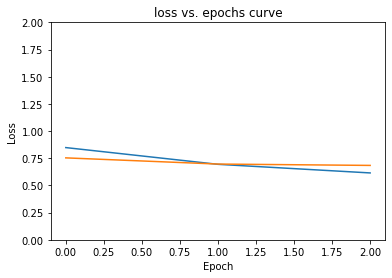

In [13]:
EPOCHS = 3
model = BertClassifier()
LR = 1e-5
# LR = 0.005
BATCH_SIZE = 64
              
train(model, train_set, validation_set, LR, EPOCHS, BATCH_SIZE)